#### Imports

In [1]:
import src.web_scraping.downloading_metrics as downloading
from src.web_scraping.downloading_countries import save_countries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import src.visualisations.plotting_utilis as my_plt
import src.data_preprocessing.utils as preprocess_utils

DOWNLOAD COUNTRIES


### Problem Statement

What are the factors influencing the median age of a country's population?
Currently, in most of the developed, as well as in the developing countries, there has been observed the phenomenon of ageing population. The main observed factors are:
1. Increase of mean and median ages
2. Decline in proportion of children and increase in proportion of elderly

Considering various metrics of country like demographic data, education, finances and even access to water or internet, we'll try to fit different regression models for median age. We'll discover how those metrics influence, and if at all, the median age.

### How Data Is Acquired

Data is scraped from website https://www.cia.gov/the-world-factbook where each country has it's own value for a given metric. Change 'download' to True to download data

In [2]:
download = True

if download:
    metrics = downloading.CATEGORICAL_METRICS + downloading.NUMERICAL_METRICS
    downloading.download_metrics(metrics)

### Explanatory Data Analysis

First, we'll explore the most important metrics: median age and age structure. Even though the only metric predicted will be the median age (for simplicity), the age structure will help to see if there are some outliers.

##### Age visualisation

In [3]:
median_age = downloading.open_metric('median age')
age_structure = downloading.open_metric('age structure')

In [4]:
nan_index = median_age[median_age['total'].isna()].index
print(nan_index)
median_age = median_age.drop(nan_index)

Index(['Holy See'], dtype='object', name='country')


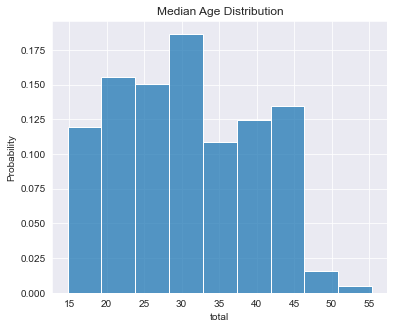

In [5]:
plt.figure(figsize=(6, 5))
sns.histplot(data=median_age, x='total', stat='probability')
_ = plt.title('Median Age Distribution')

In [6]:
median_age['total'].describe()

count    193.000000
mean      30.574611
std        9.102480
min       14.800000
25%       23.500000
50%       29.800000
75%       38.400000
max       55.400000
Name: total, dtype: float64

##### Fitting median age to distribution
Is the data normal? + use Parzen estimator

#### Age Pyramid
The following plots show the age structure for each country, where they are sorted by the increasing median age

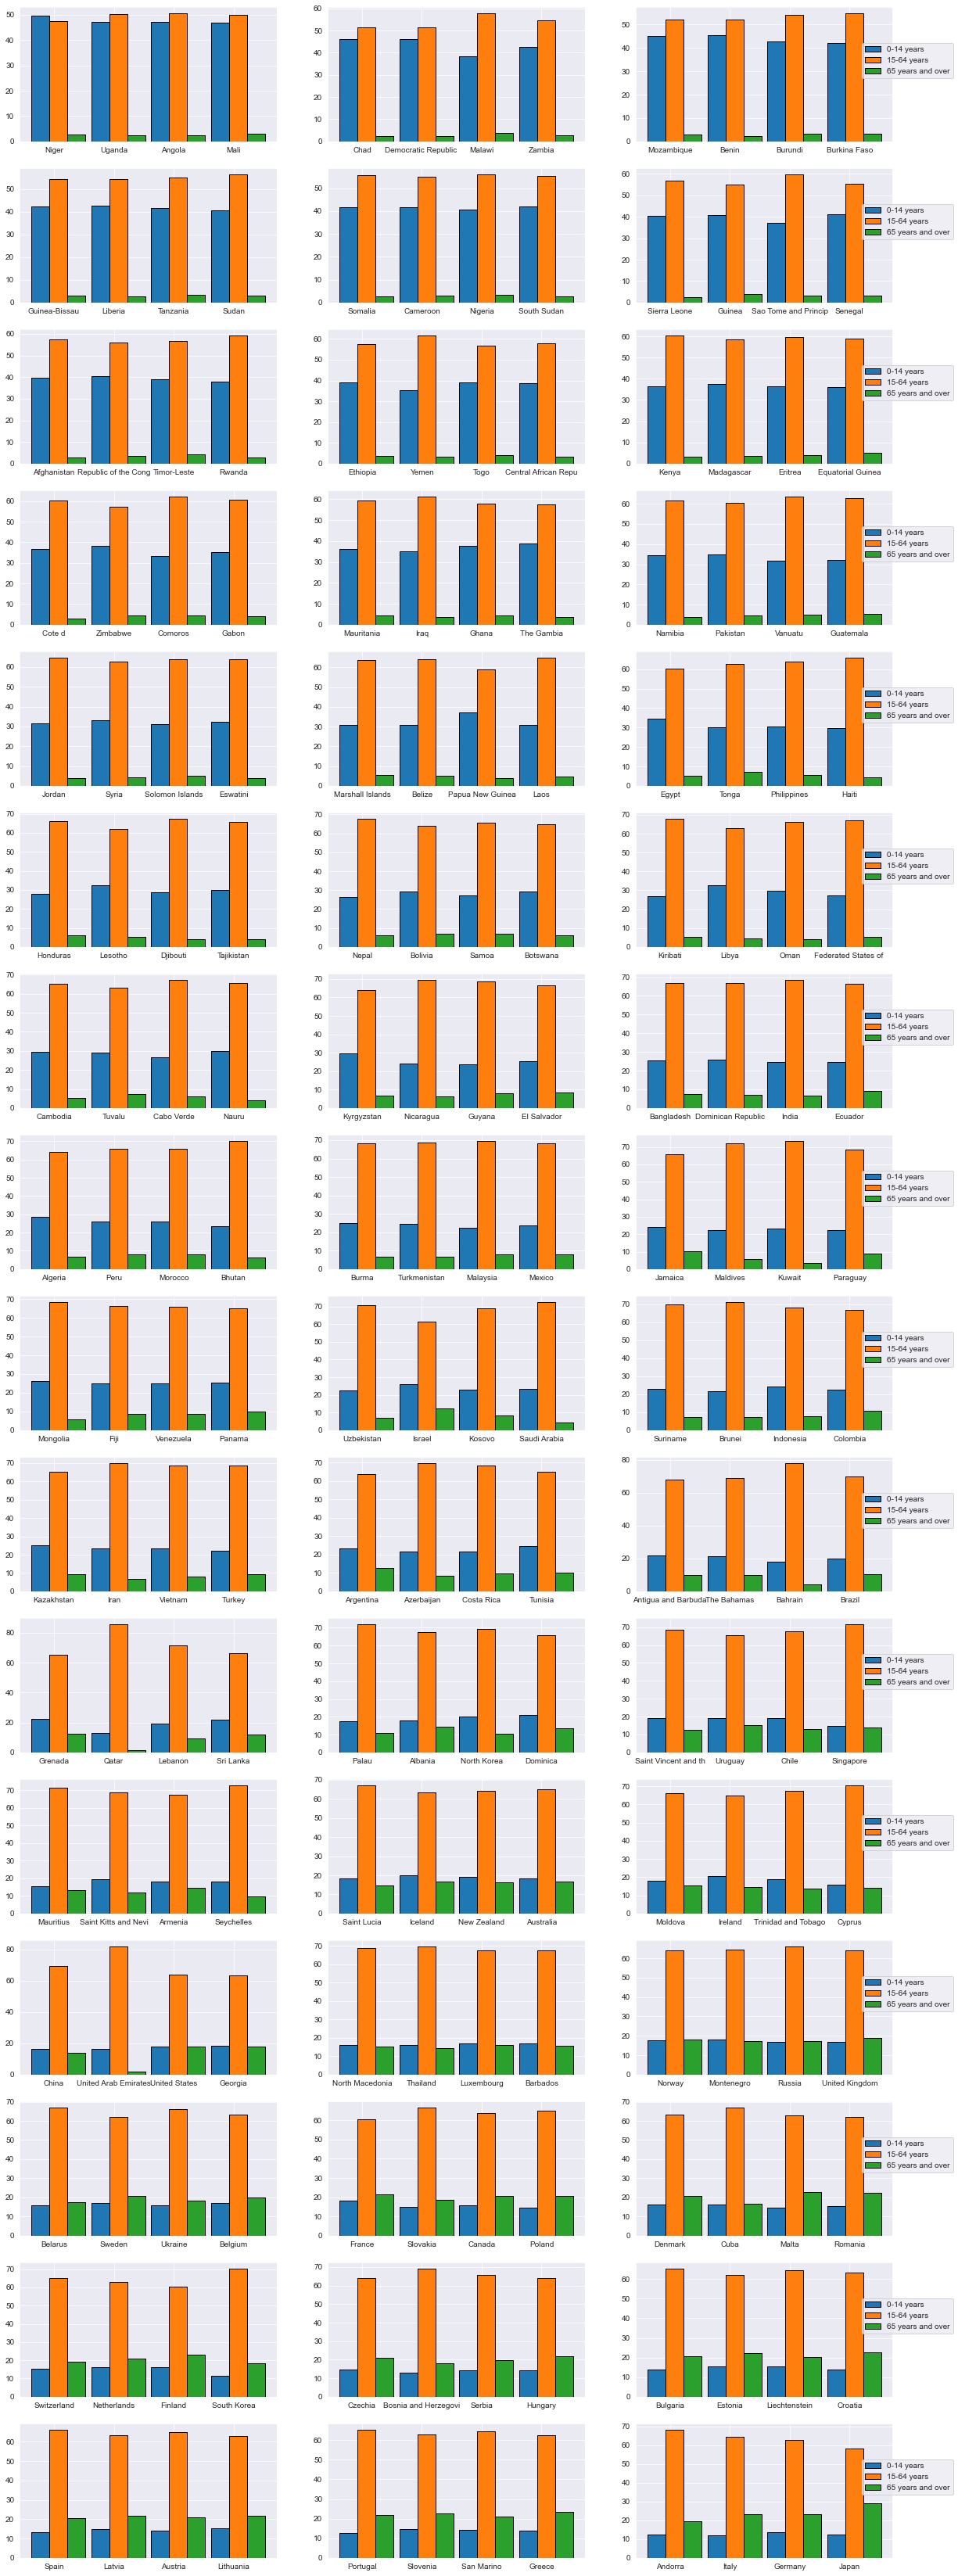

In [7]:
plt.figure(figsize=(20, 60))
my_plt.plot_age_structure(age_structure_df=age_structure, index_order=median_age['total'].sort_values().index)
plt.show()

##### Median Age By Region

It is also interesting to see whether median age depends on the region (it is almost the same as the continent).

In [8]:
country_continents = preprocess_utils.assign_continents()
country_continents.value_counts()

continent    
Africa           54
Asia             47
Europe           45
North America    23
Oceania          14
South America    12
dtype: int64

As expected, the median age distribution depends on the continent. For example, in Europe we can see the mentioned population-ageing, and for Africa (which also agrees with the above age structure plots) the prevalence of youth & children.

<Figure size 504x504 with 0 Axes>

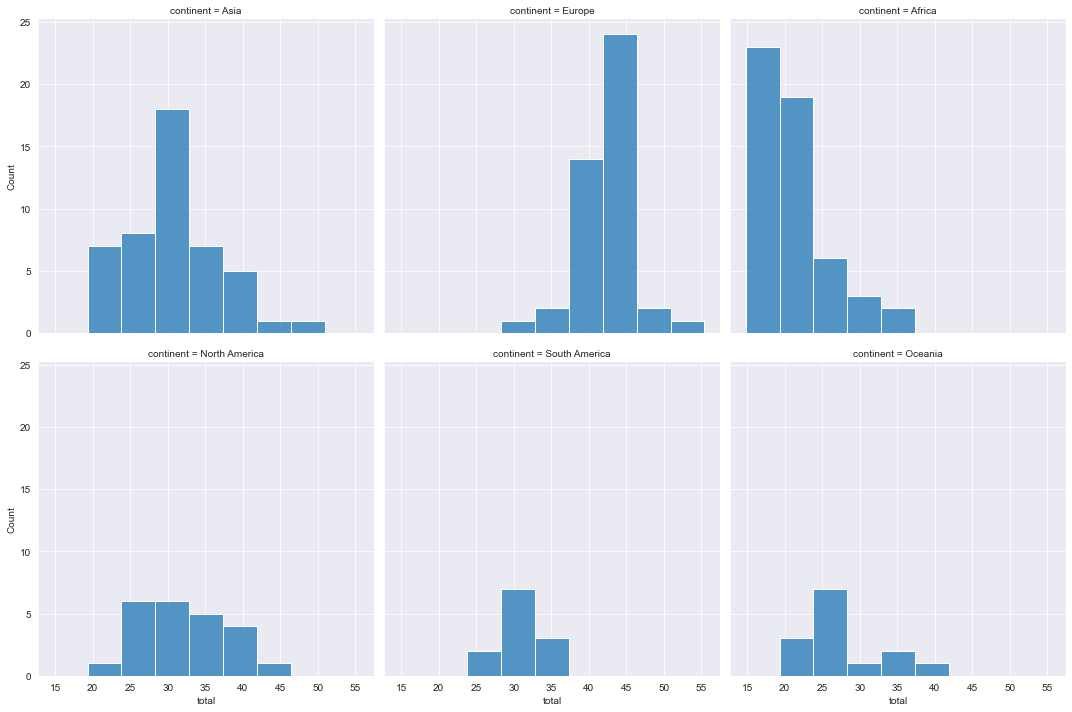

In [9]:
location = preprocess_utils.get_location_df()
plt.figure('Median Age Distribution By Regions', figsize=(7, 7))
median_age_and_continent = pd.concat([median_age['total'], country_continents['continent']], axis=1)
sns.displot(data=median_age_and_continent, x='total',
            kind='hist', col='continent', col_wrap=3)
# _ = plt.suptitle()

##### Scatterplots

Next, we'll visually analyze relationship of median age with different numerical metrics.



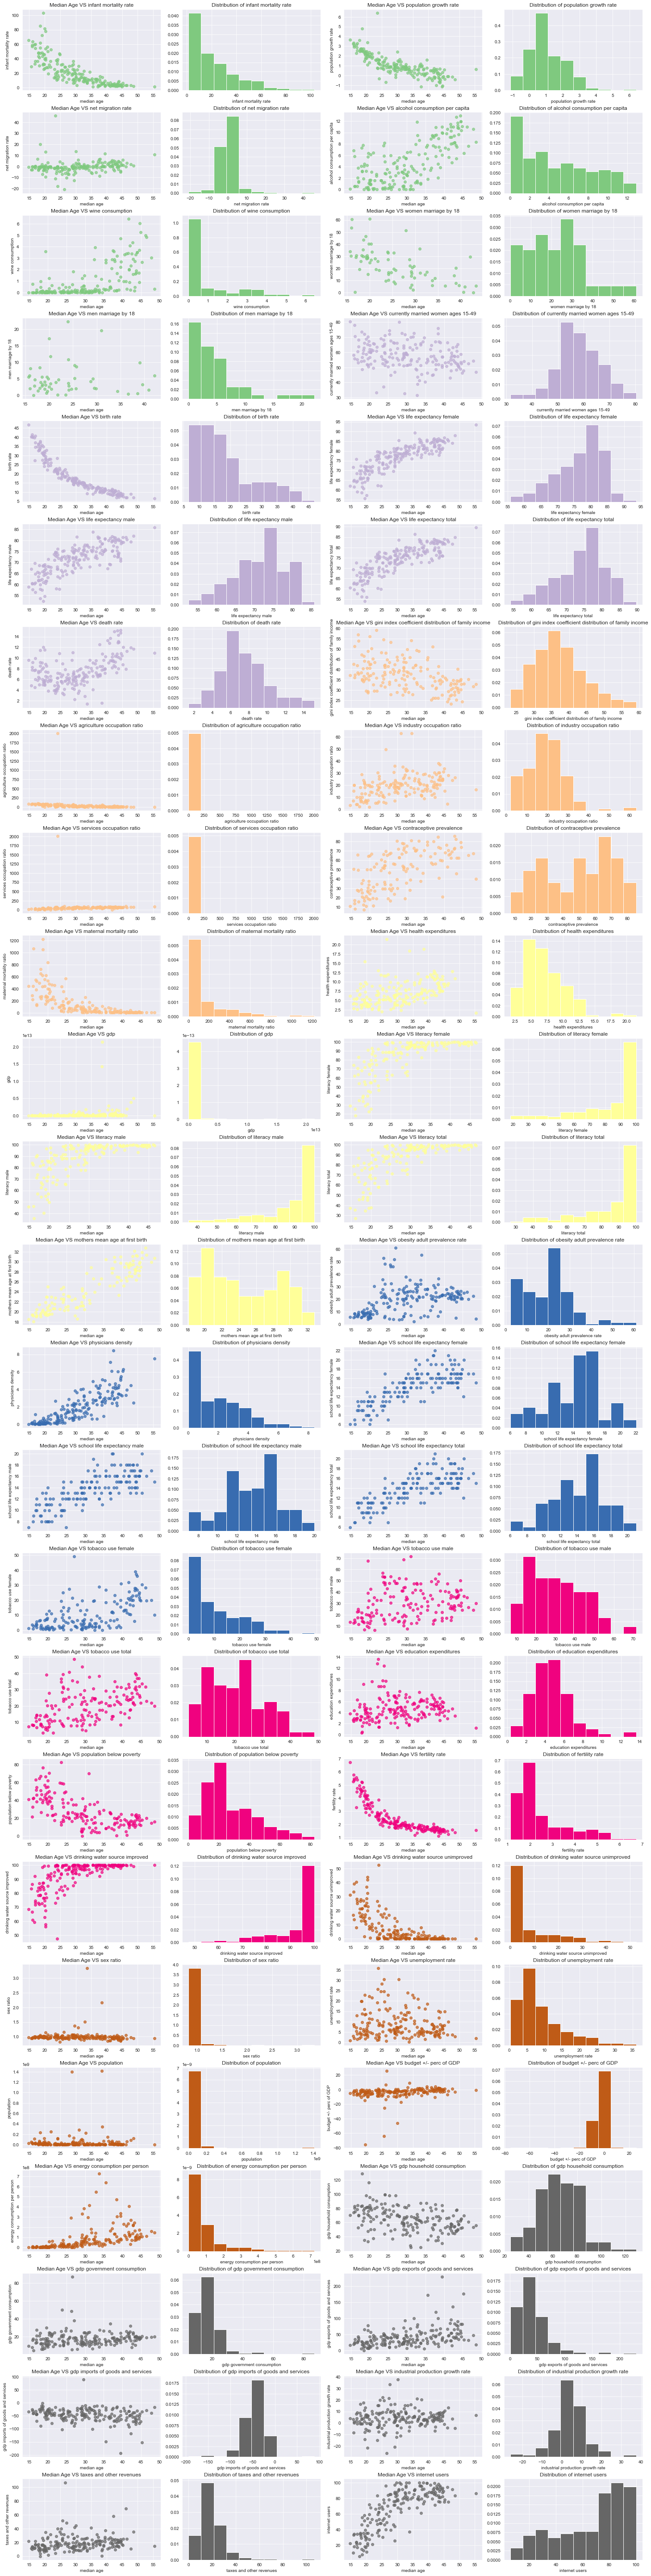

In [10]:
country_metrics = preprocess_utils.merge_metrics(median_age.index)

my_plt.create_grid_dist_and_scatter_plots(median_age, country_metrics, country_metrics.columns)

#### Introductory Feature Selection

Metrics which have given percent of missing values will be dropped

In [11]:
dropped_columns = preprocess_utils.drop_columns_with_percent_of_nulls(country_metrics)
dropped_columns

Index(['women marriage by 18', 'men marriage by 18'], dtype='object')

Looking at the plot, we can see that there are some linear correlations between data and median age, or some dependencies which are not linear. First, we'll drop features which are not correlated, for which there is almost a straight line on the plot. This way, the complexity of the model will shrink.

Pearson correlation coefficient assumes that the distributions are normal. Spearman's rank correlation coefficient is a nonparametric measure of rank correlation. We'll also try these metrics on logarithm of data, because some seem to follow this pattern.

In [12]:
from scipy.stats import pearsonr, spearmanr



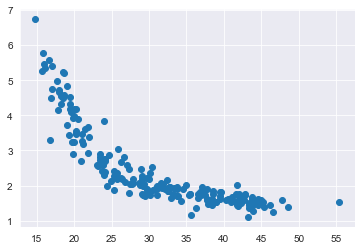

In [13]:
plt.scatter(median_age['total'],
            country_metrics['fertility rate'])

<AxesSubplot:>

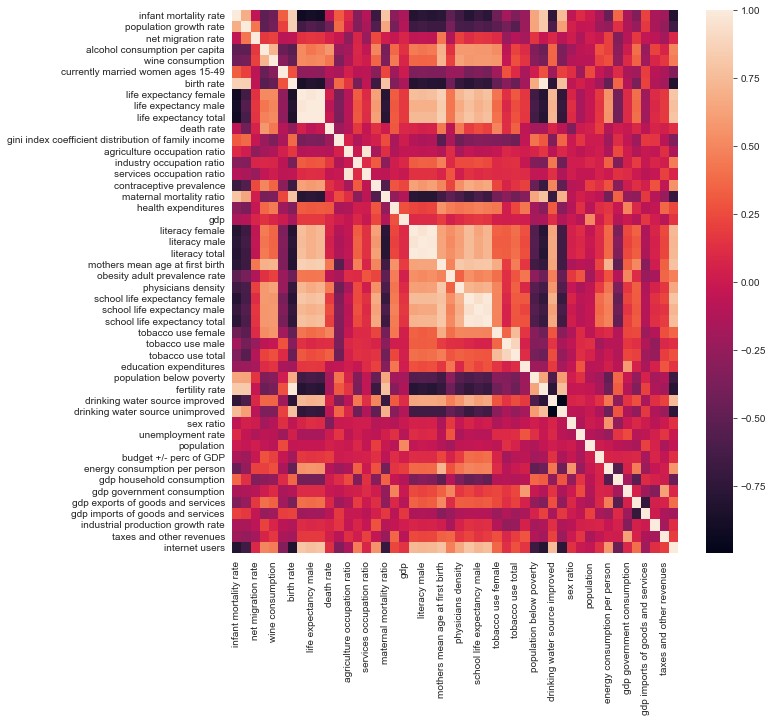

In [14]:
correlation_matrix = country_metrics.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix)

#### Data Preparation

Next, we'll replace NAN values

### Regression Models